In [102]:
def load(predicted, gold):
    out = []
    for file_name in [predicted, gold]:
        with open(file_name, 'r') as f:
            out.append(f.read().splitlines())
    return out
    
    
predicted, gold = load('./output/predicted12j.txt', './data/heb-ctrees.joint')
assert len(predicted)<=len(gold)

In [103]:
import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [135]:
def load_eval(file_name):
    out = defaultdict(dict)
    t_tags = ['index', '_', '_', '_', 'parent', 'tag']
    nt_tags = ['index', '_', '_', '_', 'start', 'end', 'tag']
    meta_tags = ['ID', 'Len.', 'Stat.', 'Recal', 'Prec.', 'Matched Bracket', 'Bracket gold', 'Bracket test', 'Cross Bracket', 'Words', 'Correct Tags', 'Tag Accracy']
    with open(file_name, 'r') as f:
        started = False

        for line in f:
            split = [word for word in line.strip().split(' ') if word]
            if len(split) == 12:
                try:
                    _ = float(split[-2])  # is item before last a float
                    line_num = int(split[0])
                    out[line_num]['line'] = gold[line_num - 1]
                    out[line_num]['meta'] = dict(zip(meta_tags, map(float, split)))
                    continue
                except ValueError:
                    pass

            if line == '============================================================================\n':
                if not started:
                    started = True
                else:
                    return out  # ended
            elif not started:
                continue
            else:
                if len(split) == 12 or len(split) == 14:
                    parsing_terminals = len(split) == 12
                    keys = ['t-predicted', 't-gold'] if parsing_terminals else ['nt-predicted', 'nt-gold']
                    tags = t_tags if parsing_terminals else nt_tags

                    half = int(len(split) / 2)
                    for i, place in enumerate(keys):
                        out[line_num][place] = out[line_num].get(place, [])
                        place_tags = zip(tags, split[i * half:(i + 1) * half])
                        out[line_num][place].append(dict(place_tags))
    return out


evalb = load_eval('output/evalb-result12j.txt')
RenderJSON(evalb)

In [139]:
import pandas as pd

data = [r['meta'] for r in evalb.values()]
df = pd.DataFrame(data)
df.corr()['Len.']

Bracket gold       0.988149
Bracket test       0.987114
Correct Tags       0.986471
Cross Bracket      0.828903
ID                 0.606462
Len.               1.000000
Matched Bracket    0.934642
Prec.             -0.101653
Recal             -0.107417
Stat.             -0.092986
Tag Accracy        0.186249
Words              1.000000
Name: Len., dtype: float64

In [150]:
df.loc[10]

Bracket gold       10.0
Bracket test       10.0
Correct Tags        6.0
Cross Bracket       3.0
ID                 11.0
Len.                8.0
Matched Bracket     6.0
Prec.              60.0
Recal              60.0
Stat.               0.0
Tag Accracy        75.0
Words               8.0
Name: 10, dtype: float64

In [154]:
import dill
pickle_file = "./pcfg.p"
with open(pickle_file, "rb") as f:
    pcfg = dill.load(f)

In [163]:
pcfg.reverse_rules["T"]["B"]

[('IN', ('B',), 0.34907143926913287),
 ('NNP', ('B',), 0.001472987120492781),
 ('ZVL', ('B',), 0.0006556986170720077)]

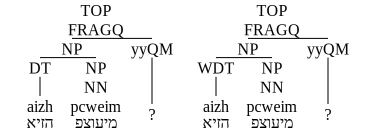

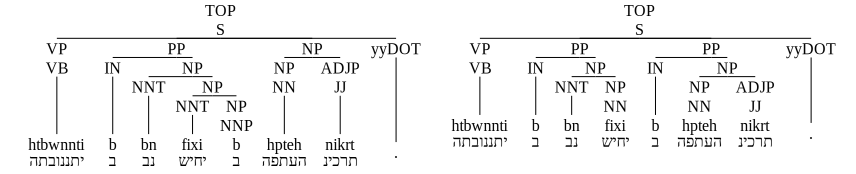

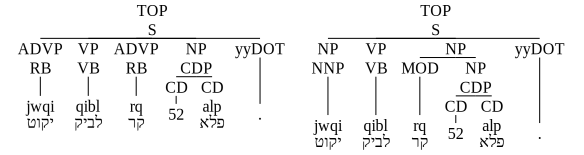

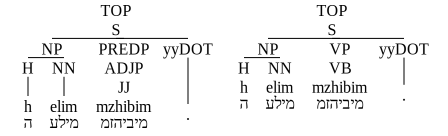

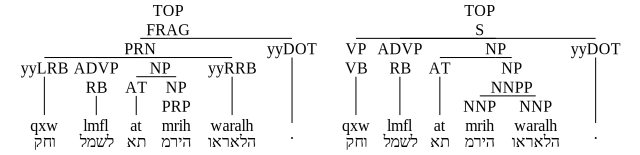

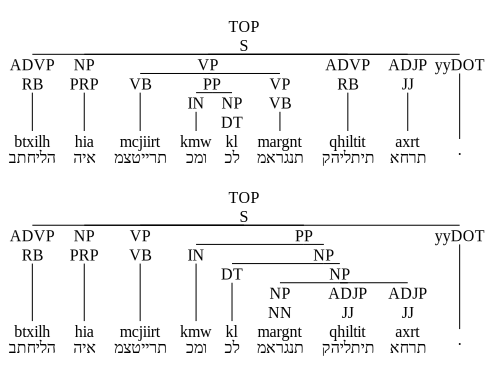

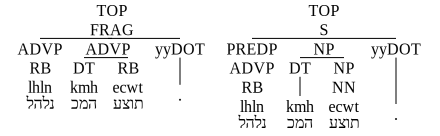

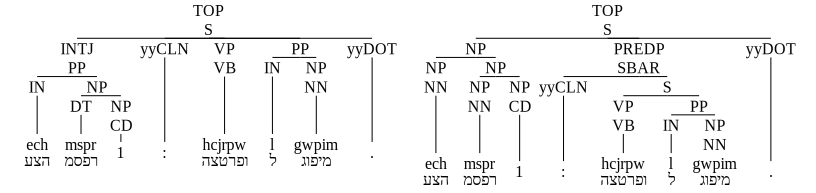

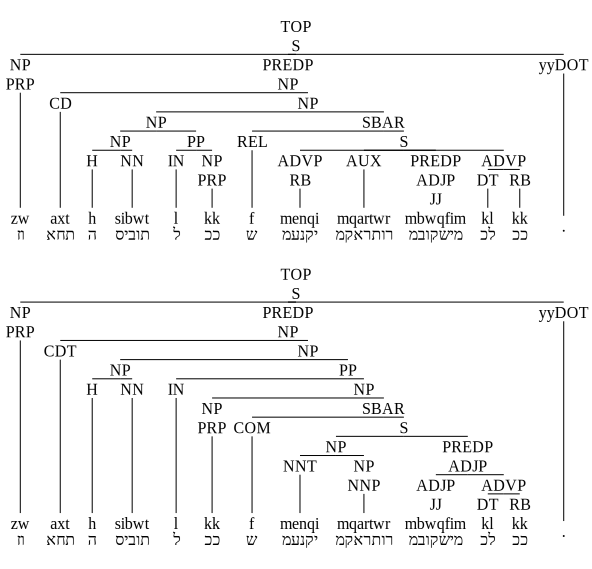

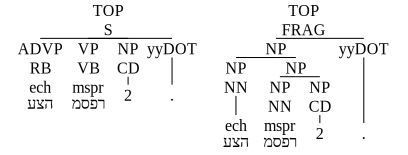

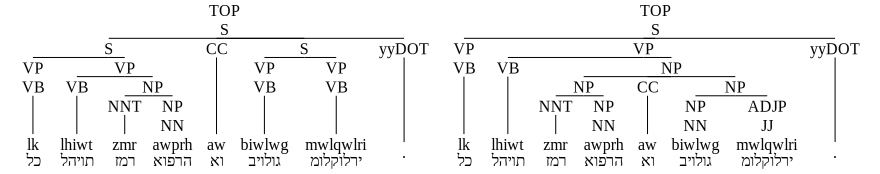

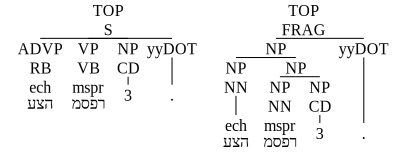

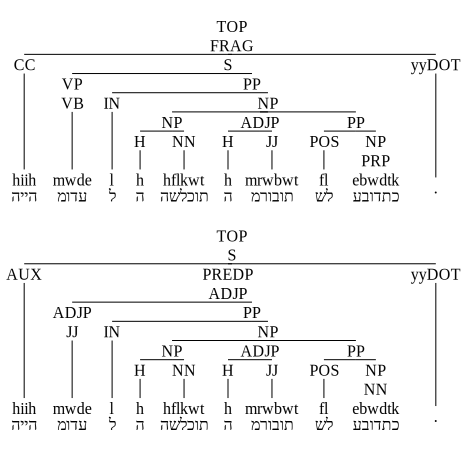

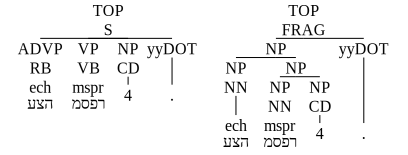

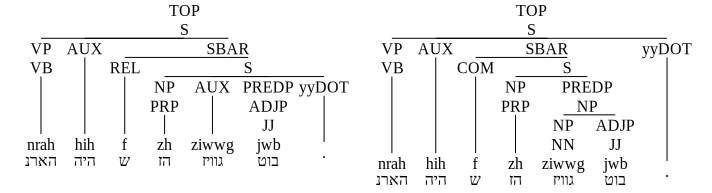

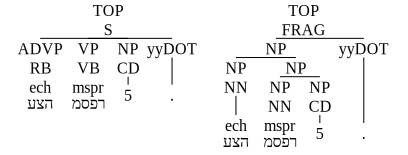

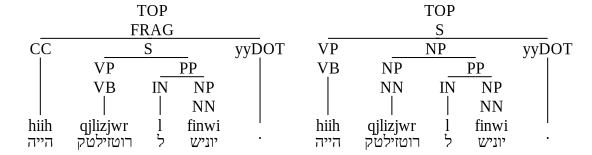

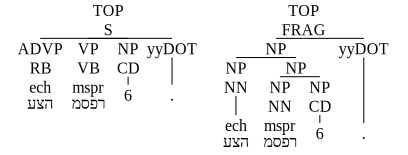

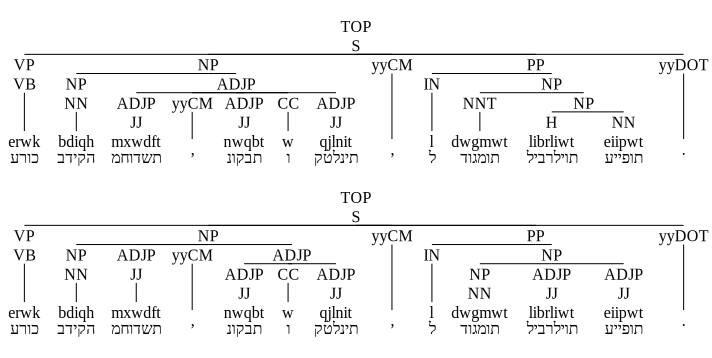

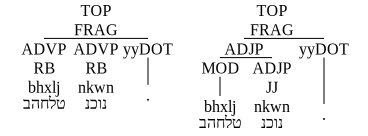

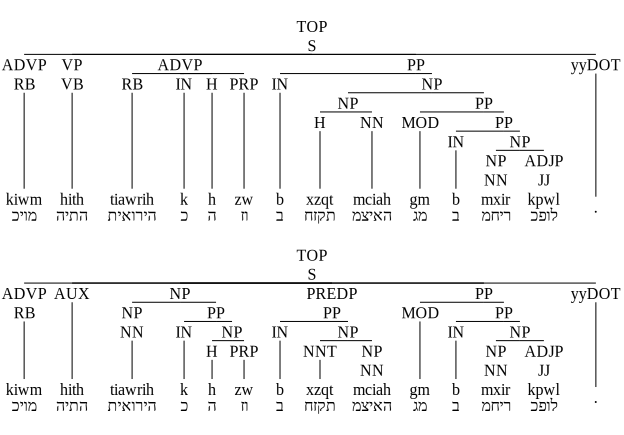

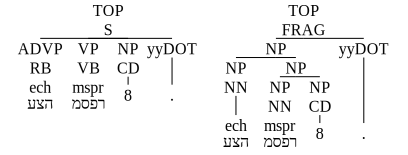

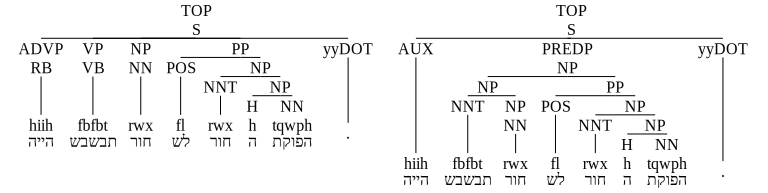

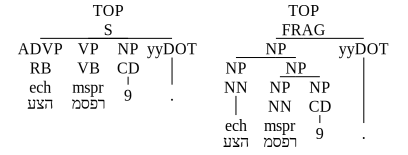

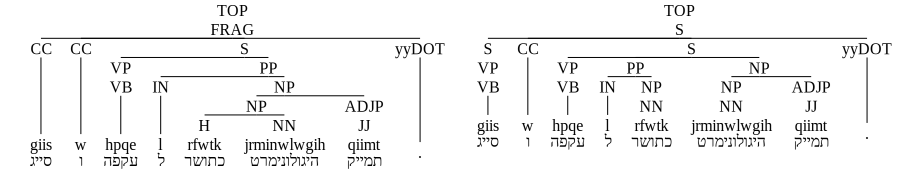

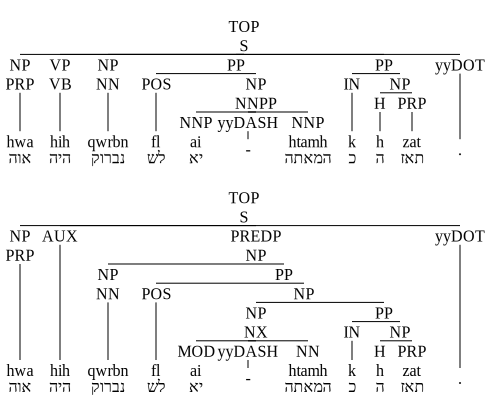

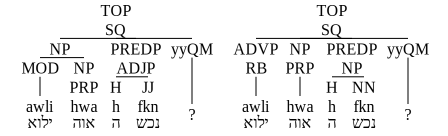

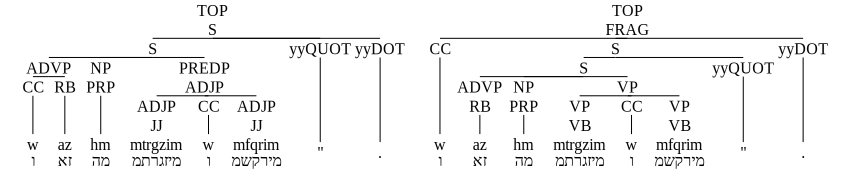

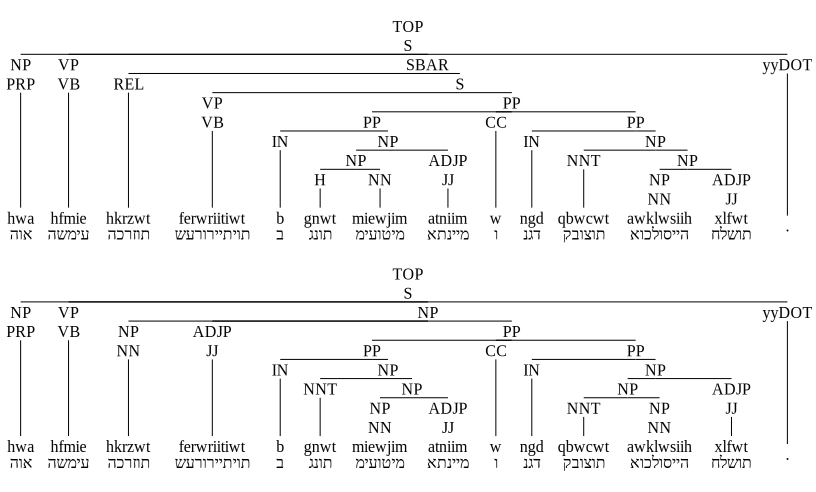

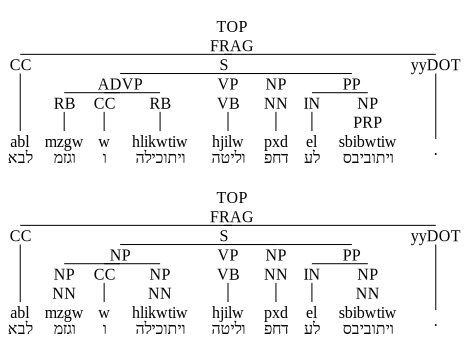

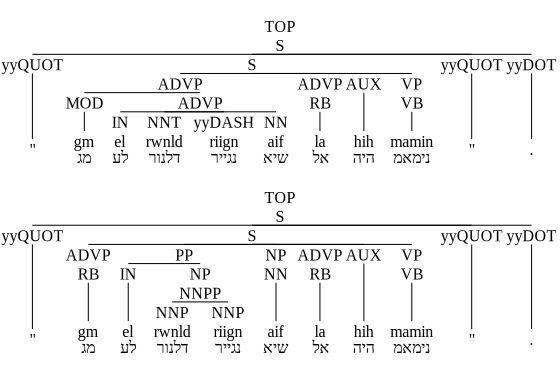

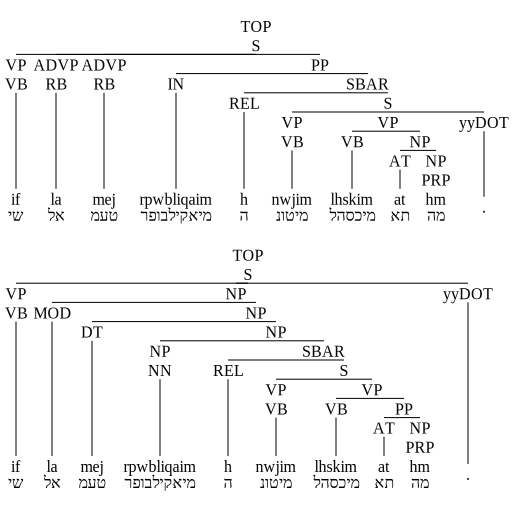

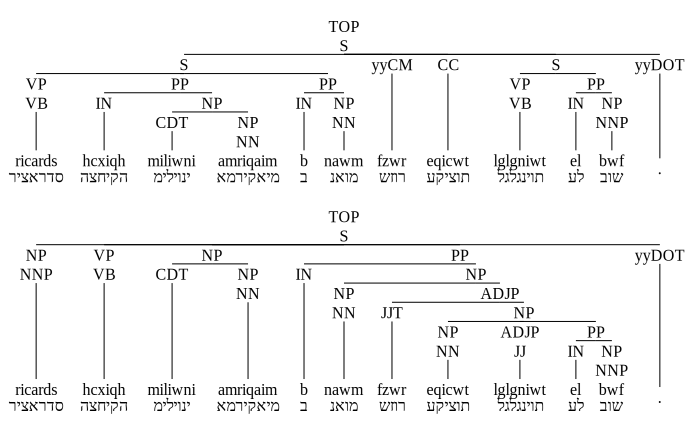

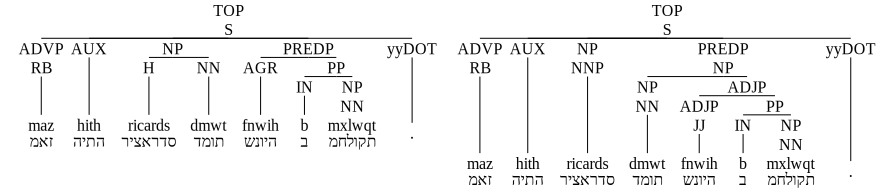

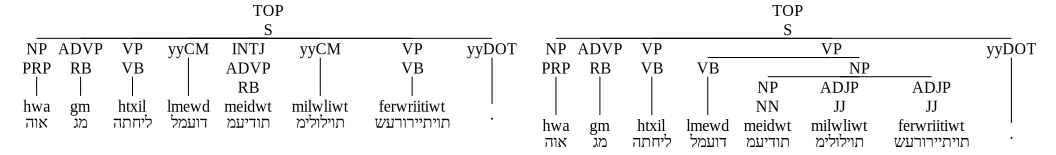

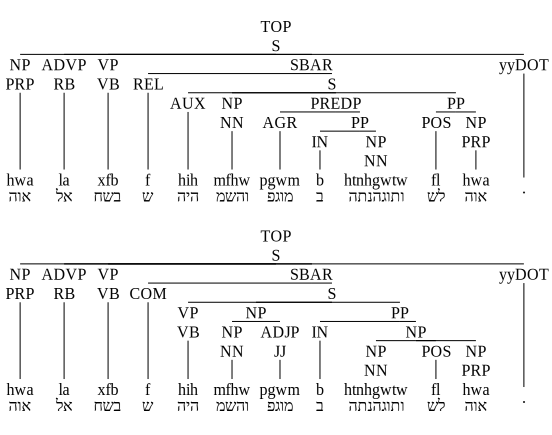

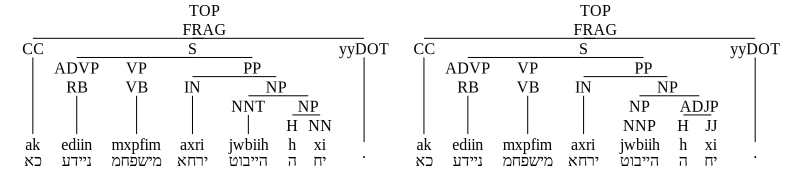

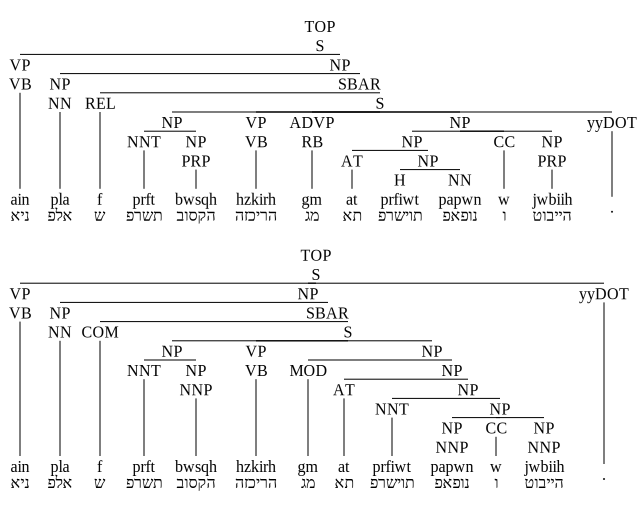

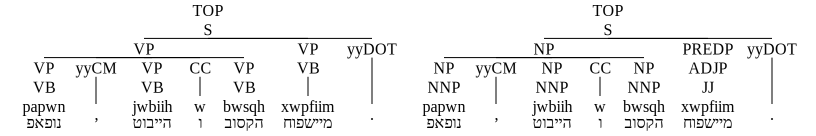

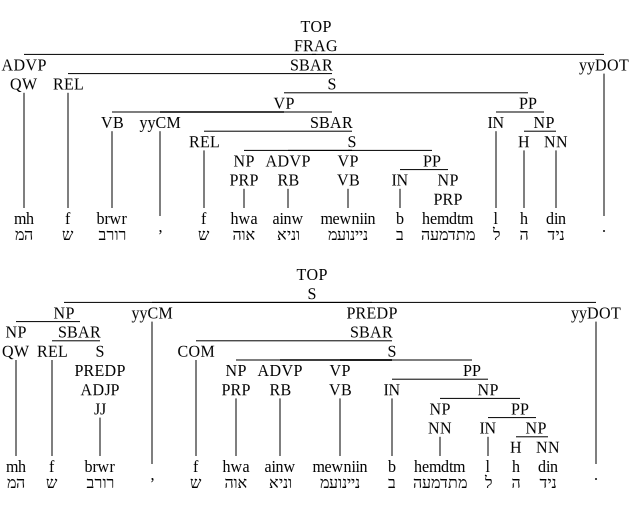

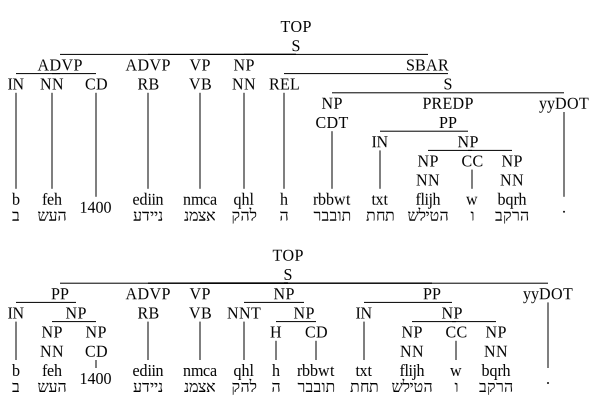

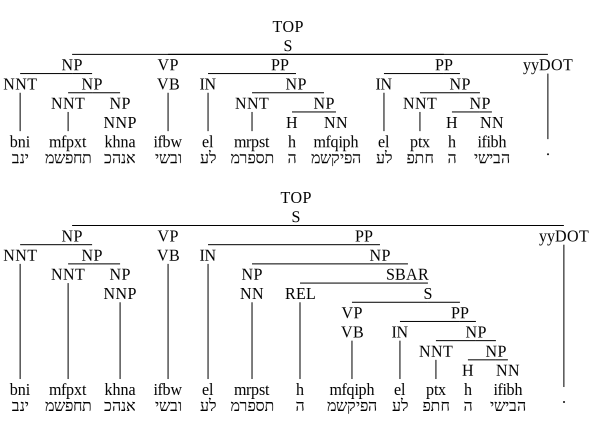

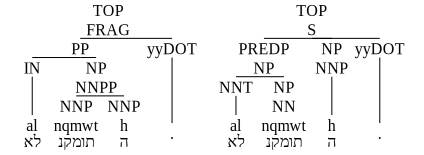

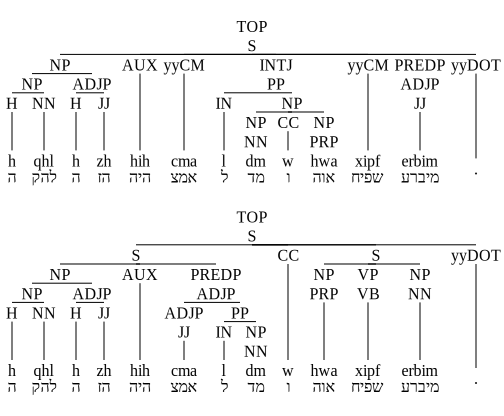

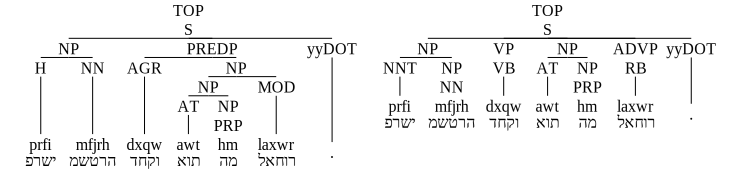

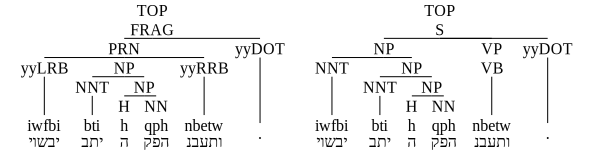

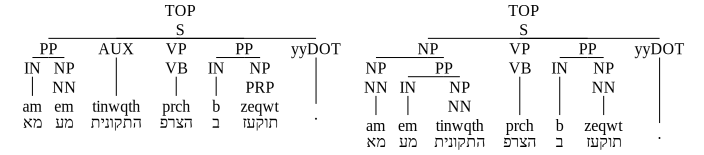

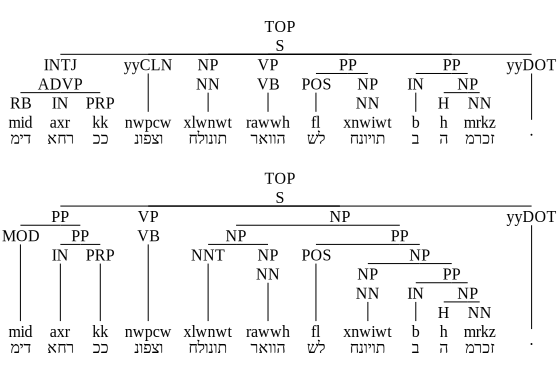

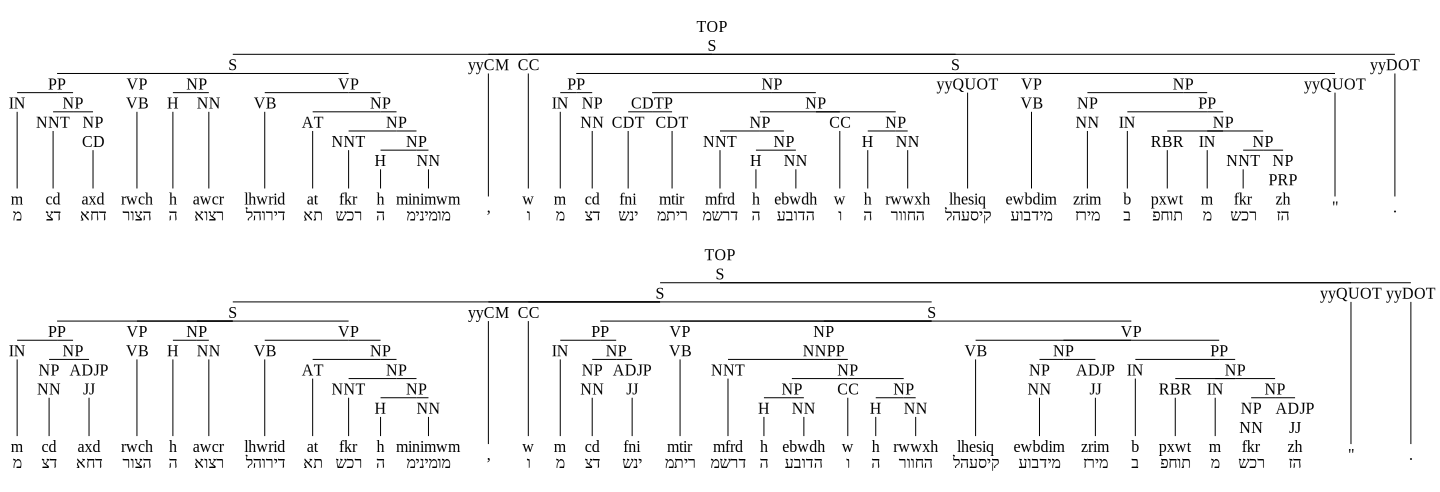

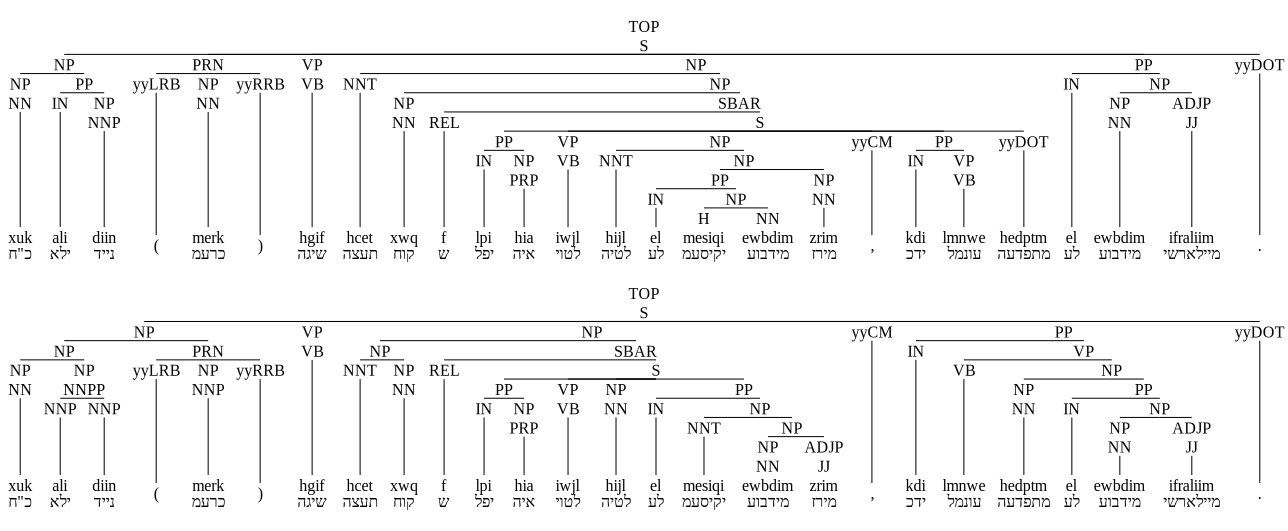

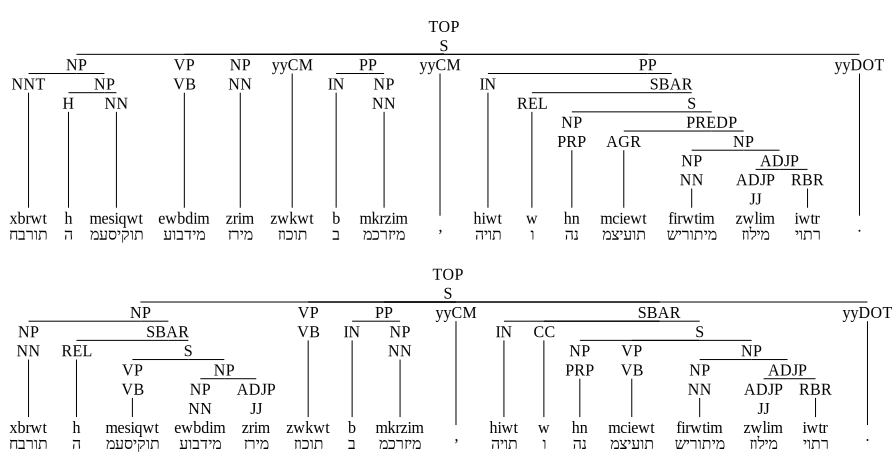

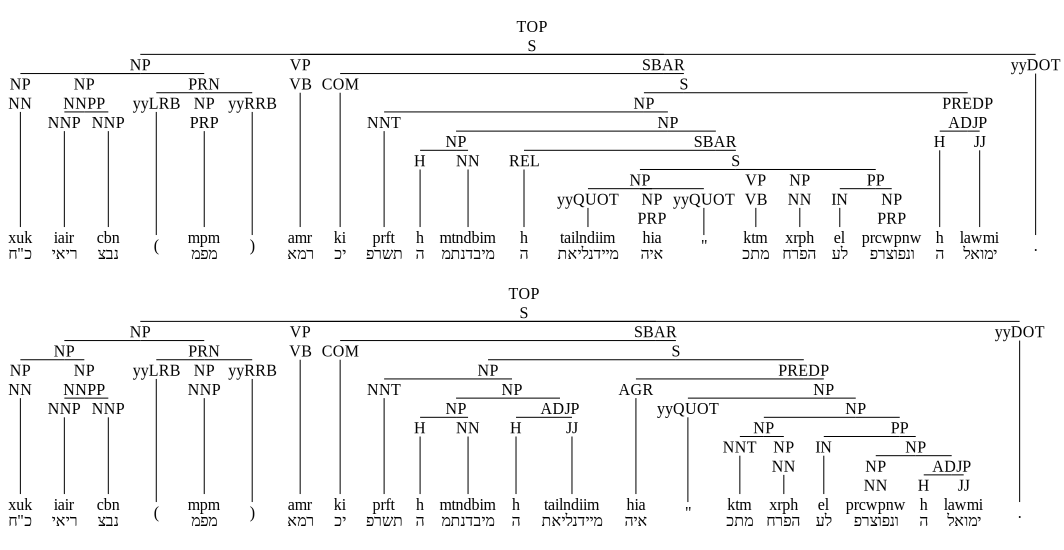

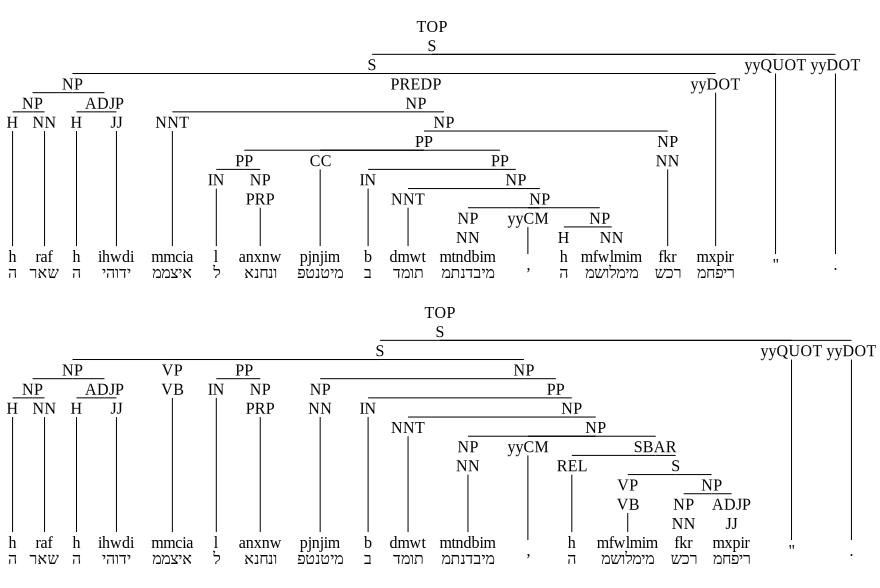

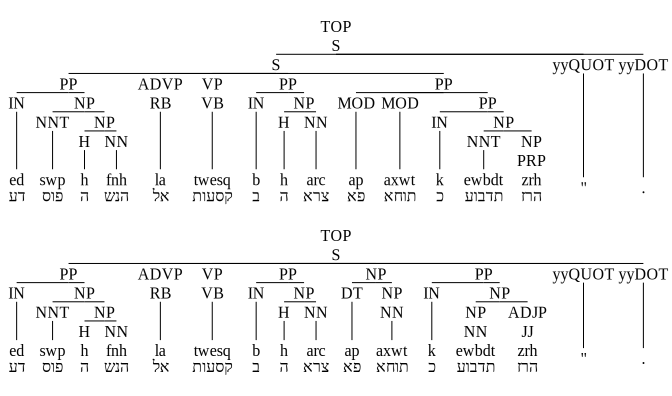

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [275]:
import svgling, svgling.html, svgling.figure
from svgling.figure import SideBySide, RowByRow, Caption
from svgling.core import VertAlign
import json
import re
from util.transliteration import to_heb, _trans_symbols
from IPython.core.display import display, HTML

def translate(word):
    if word in _trans_symbols:
        ret = to_heb(word)
        if ret=='"':
            return "\\\""
        return ret
    else:
        return word.lower()+"\\n"+"".join(map(to_heb, word)).replace('"', "\\\"")

def translate_replace(word):
    return word.group(1) + translate(word.group(2)) +  word.group(3)
    

def to_graph(line):
    formatted = line.replace("(","[").replace(")","]")
    formatted = re.sub(r'([a-zA-Z]+)', r'"\1"',formatted)
    formatted = re.sub(r'(\s\")([a-zA-Z]+)(\"\])', translate_replace, formatted)
    formatted = re.sub(r'\s', r',',formatted)
    graph = json.loads(formatted)
    try:
        graph = json.loads(formatted)
    except:
        print(formatted)
        exit(1)
    return graph

def html(text, tag):
    display(HTML(f'<{tag}>{text}</{tag}>'))

def h1(text):
    html(text, 'h1')

def h2(text):
    html(text, 'h2')
    

def describe(line_num, p_boxes=None, g_boxes=None):
    meta = evalb[line_num]['meta']
    h2(f'Line {line_num}')
    
    pred_graph = svgling.draw_tree(to_graph(predicted[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    gold_graph = svgling.draw_tree(to_graph(gold[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    
    for b in p_boxes or []:
        pred_graph.box_constituent(b)
    for b in g_boxes or []:
        gold_graph.box_constituent(b)
    
    printer = SideBySide if meta['Len.']<9 else RowByRow
    display(printer(pred_graph,gold_graph))
        
for i, line in enumerate(predicted):
    meta = evalb[i+1]['meta']
    if meta['Tag Accracy']<80:
        describe(i+1)

In [305]:
def get_parent_to_child(parent, child, child_side):
    index = 0 if child_side=='left' else 1
    parent_to_child = dict((t,prob) for t, prob in pcfg.rules[parent][pcfg.NON_TERMINAL_RULES].items() 
                           if (len(t)==2 and t[index]==child) or (len(t)==1 and t[0]==child))
    return sorted(parent_to_child.items(), key=lambda t:-t[1])

def get_possible_terminal_tags(terminal):
    return pcfg.reverse_rules['T'].get(terminal.upper(), [])

def get_unknown_score(terminal):
    unknowns = sorted(pcfg.unknown_rules, key=lambda k: -pcfg.unknown_rules[k]) 
    return unknowns.index(terminal)

## First, let's examin some mistakes:

As we can see in the example below, the marked tokens got the wrong tag, and consequently changed the sentence tree.

This happened as __שיחי__ appeared in the train set only as MNT, which meant 'the bushes of', in a totally different meanining than in the parsed sentence.

This use case shows the CKY may fail to parse sentence with __tokens that have several meanings__, but only appeared with one in the traning.

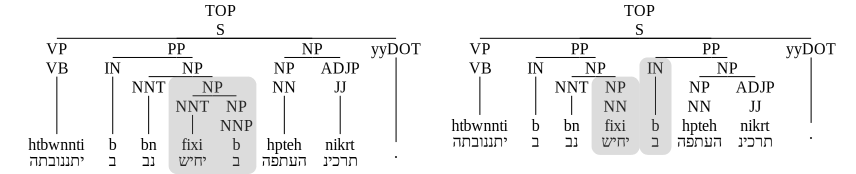

In [339]:
describe(11, [(0,1,1,1)], [(0,1,1,1), (0,2,0)])
token_parents = ", ".join([t[0] for t in get_possible_terminal_tags('FIXI')])
h3(f"שיחי parents: {token_parents}")

---
As we can see below, the mistake here is marking __איזה__ as DT instead of WDT (question determiner)

We can see that איזה was indeed learnt to be a WDT in most cases, but NP is much more likely to be a parent of __DT X__ than a __WDT X__.

This use case shows the CKY may fail to parse less common sentence forms, like __questions__.

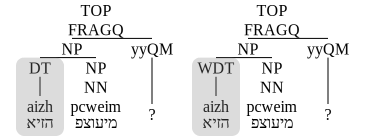

[('WDT', ('AIZH',), 0.0025128708016670747),
 ('DT', ('AIZH',), 0.0008810203054203724)]

[(('WDT', 'NP'), 0.00031025980176031614),
 (('WDT',), 8.164731625271477e-05),
 (('WDT', 'WDT*IN-NP'), 3.265892650108591e-05)]

[(('DT', 'NP'), 0.011136693936870294),
 (('DT', 'DT*IN-NP'), 0.00022861248550760135),
 (('DT', 'SBAR'), 0.00013063570600434365)]

In [340]:
describe(5, [(0,0,0)], [(0,0,0)])
h3("איזה parents")
display(get_possible_terminal_tags('aizh'))
h3("NP->WDT relation")
display(get_parent_to_child("NP","WDT","left"))
h3("NP->DT relation")
display(get_parent_to_child("NP","DT","left")[0:3])

---
As we can see, the marked token got the wrong tag, and consequently changed the sentence tree.

This happened as __טוקי__ didn't appear in the traning set at all.

In this case, we try to guess its POS based on a smoothing algorithm. Here it choose RB was has a better score than any noun tag, as טוקי appeared to be in the gold parse.

This use case shows the CKY will find it harder to parse sentences with __unknown words__.

Same thing accors below, as __מזהיבים__ isn't a known word:

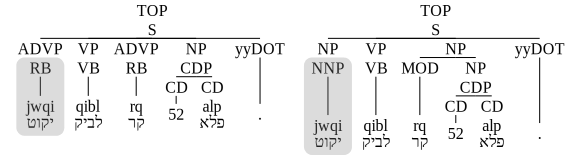

[]

25

30 32 36


In [337]:
describe(12, [(0,0,0)], [(0,0,0)])
h3("טוקי parents")
display(get_possible_terminal_tags('jwqi'))
h3("RB (adverb) score for unknown words (lower is better):")
display(get_unknown_score("RB"))
h3("NNP, NNT, NN scores for unknown words:")
print(get_unknown_score("NNP"), get_unknown_score("NNT"), get_unknown_score("NN"))

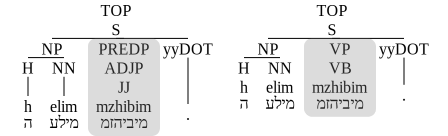

In [336]:
describe(24, [(0,1,)], [(0,1,)])

---
Here, frankly, it seems like a __mistake in the gold data__.

There's no reason why __אולי__ be a adverb in this sentence.

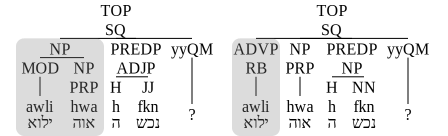

In [342]:
describe(61, [(0,0,)], [(0,0,)])

---
Many mistakes happen when parsing __proper nouns__, like __people names__, these are more unknown words that aren't treated properly.

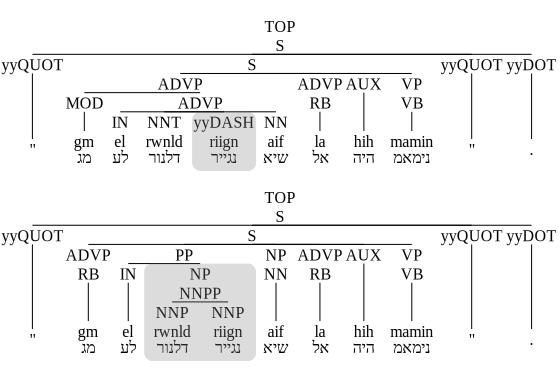

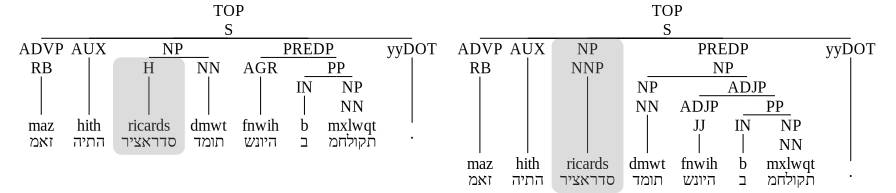

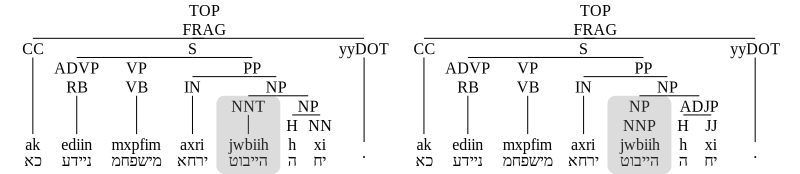

In [372]:
describe(71, [(0,1,0,1,2)], [(0,1,1,1)])
describe(83, [(0,2,0)], [(0,2,)])
describe(101, [(0,1,2,1,0)], [(0,1,2,1,0)])

In [109]:
import networkx as nx
from collections import deque
from util.tree.builders import node_tree_from_sequence

def to_graph(line):
    G=nx.DiGraph()
    q = deque()
    node = node_tree_from_sequence(line)
    q.append((node, 0))
    while q:
        node,level = q.popleft()
        children = node.children
        if len(children):
            q.extend([(c, level+1) for c in children])
            for c in children:
                G.add_edge(f"{node.tag}-{level}",f"{c.tag}-{level+1}")
    return G

In [116]:
import networkx as nx
def draw(graph):
    pos=nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos, node_color='w')
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos)

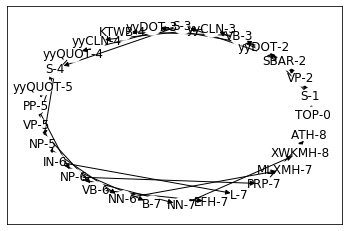

In [117]:
G=to_graph(predicted[0])
draw(G)
# nx.draw_networkx(G)

In [35]:
import networkx as nx
def analyze(predicted_line, gold_line):
    difference


In [32]:

for i, line in enumerate(predicted):
    if gold[i]==line:
        
        print(i)
        

0
3
9
12
13
17
39
53
54
79
80
85
86
90
96
97
115
117
121
125
127
131
134
138
140
143
144
145
